In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas_datareader as pdr
import datetime
today = datetime.date.today()

In [2]:
def Black_Scholes_price(S, K, T, r, sigma, option_type): # assume risk-free-rate = 0
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        option_price = S * norm.cdf(d1) - K * np.exp(-0.05 * T) * norm.cdf(d2)
    elif option_type == 'put':
        option_price = K * np.exp(-0.05 * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")
    
    return option_price

In [3]:
def Get_rfr():
    risk_free_rate = pd.DataFrame()
    shifted_date = 0
    while risk_free_rate.empty:
        risk_free_rate = pdr.DataReader('DGS3MO', 'fred', today - datetime.timedelta(days=shifted_date)).dropna()
        shifted_date += 1
    return risk_free_rate.values[0][0]/100

In [30]:
def find_arbitrage(ticker_symbol):
    ticker = yf.Ticker(ticker_symbol)
    expiration = ticker.options[0]  # Get the closest option chain
    option_chain = ticker.option_chain(expiration)
    calls = option_chain.calls
    puts = option_chain.puts

    calls['contractType'] = "call"
    puts['contractType'] = "put"
    
    current_price = ticker.info['currentPrice']
    risk_free_rate = Get_rfr()
    for df in [calls, puts]:
        df['TheoreticalPrice'] = np.where(
            df['impliedVolatility'] > 0,
            Black_Scholes_price(current_price, df['strike'], (pd.Timestamp(expiration) - pd.Timestamp.now()).days / 365,
                                        risk_free_rate, df['impliedVolatility'], df['contractType'].iloc[0]),
            np.nan
        )
    
    calls['Arbitrage'] = calls['TheoreticalPrice'] - calls['ask']
    puts['Arbitrage'] = puts['TheoreticalPrice'] - puts['ask']
    
    significant_calls = calls[calls['Arbitrage'] > calls['ask'] * 0.05]
    significant_puts = puts[puts['Arbitrage'] > puts['ask'] * 0.05]

    print(f'The current price for {ticker_symbol} is {current_price},')
    print(f"Found {len(significant_calls)} potential call arbitrage opportunities")
    print(f"Found {len(significant_puts)} potential put arbitrage opportunities")
    
    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.scatter(calls['strike'], calls['Arbitrage'], label='Calls', alpha=0.5)
    plt.scatter(puts['strike'], puts['Arbitrage'], label='Puts', alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Strike Price')
    plt.ylabel('Arbitrage Opportunity ($)')
    plt.title(f'Option Arbitrage Opportunities for {ticker_symbol}')
    plt.legend()
    plt.show()
    
    return significant_calls, significant_puts

The current price for NOW is 919.04,
Found 1 potential call arbitrage opportunities
Found 12 potential put arbitrage opportunities


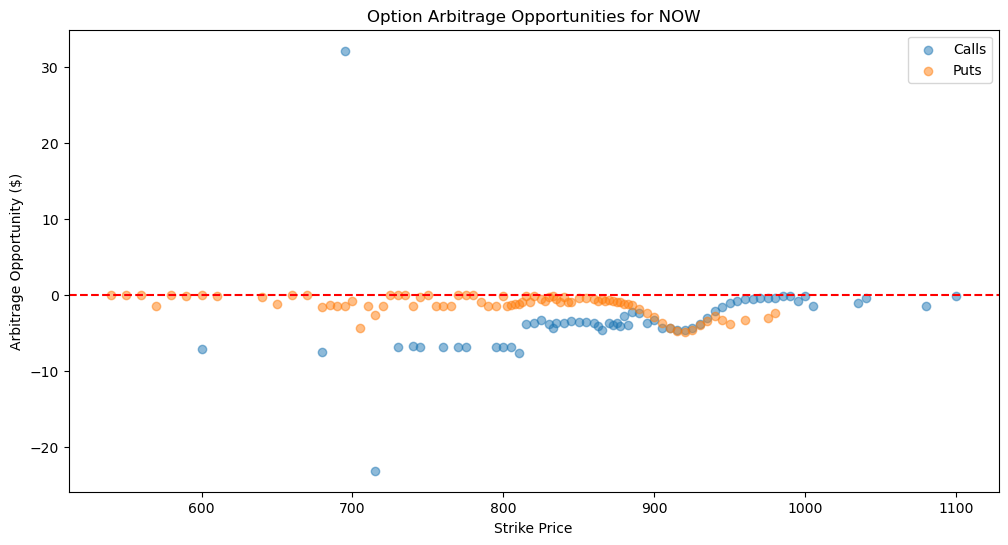


Top 5 Call Arbitrage Opportunities:
----------------------------------------
       contractSymbol             lastTradeDate  strike  lastPrice    bid  \
2  NOW240927C00695000 2024-08-16 15:09:13+00:00   695.0      140.4  179.6   

     ask  change  percentChange  volume  openInterest  impliedVolatility  \
2  192.0     0.0            0.0     1.0             2            0.00001   

   inTheMoney contractSize currency contractType  TheoreticalPrice  Arbitrage  
2        True      REGULAR      USD         call        224.135199  32.135199  

Top 5 Put Arbitrage Opportunities:
-----------------------------------------
        contractSymbol             lastTradeDate  strike  lastPrice  bid  ask  \
26  NOW240927P00750000 2024-09-23 14:25:16+00:00   750.0       0.17  0.0  0.0   
23  NOW240927P00735000 2024-09-17 13:40:41+00:00   735.0       0.67  0.0  0.0   
22  NOW240927P00730000 2024-09-20 19:59:01+00:00   730.0       0.05  0.0  0.0   
21  NOW240927P00725000 2024-09-17 13:40:41+00:00   7

In [34]:
significant_calls, significant_puts = find_arbitrage("NOW")

# Display the top 5 arbitrage opportunities for calls and puts
print("\nTop 5 Call Arbitrage Opportunities:")
print('----------------------------------------')
print(significant_calls.sort_values('Arbitrage', ascending=False).head(5))
print("=======================================================================================")
print("\nTop 5 Put Arbitrage Opportunities:")
print('-----------------------------------------')
print(significant_puts.sort_values('Arbitrage', ascending=False).head(5))